In [2]:
import sys, os, decimal, json
sys.path.append(os.path.realpath('..'))
import json, time
import pandas as pd
import random
import matplotlib.pyplot as plt
import glob

import matplotlib.pyplot as plt
import numpy as np
import PIL, json
import tensorflow as tf
import socket
import pathlib
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageOps

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard

from sklearn.metrics import confusion_matrix

from TrainingPipelines.ImageClassifier.ModelBuilder import build_and_train

import seaborn as sns
import mplcyberpunk

plt.style.use("cyberpunk")
plt.rcParams['figure.facecolor'] = '#0d1117'
plt.rcParams['axes.facecolor'] = '#0d1117'
plt.rcParams['savefig.facecolor'] = '#0d1117'

In [23]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [35]:
reduction = 1

img_width = int(500/reduction)
img_height = int(600/reduction)

In [36]:
image_names = []
path = pathlib.Path(r'O:\eve_models\training_data\route_y')
for data in glob.glob(f"{path}\*.png"):
    file = data.split('\\')[-1:][0]
    image_names.append(file)

In [37]:
random.shuffle(image_names)

In [38]:
image_data = {}
f = open(f"{path}\\boxes.json")
image_data_raw = json.load(f)
f.close()

for data in image_data_raw:
    image_data[data['image_name']] = data['bbox'][0:2]
image_data[list(image_data.keys())[0]]

[136, 377]

In [39]:
train_names, val_names, test_names = np.split(image_names, [int(len(image_names)*0.8), int(len(image_names)*0.9)])

In [40]:
train_x = []
for image_name in tqdm(train_names):
    try:
        img = Image.open(f"{path}\\{image_name}")
        if reduction != 1:
            img = img.resize((img_width, img_height), resample=Image.Resampling.LANCZOS)
        train_x.append(np.array(img))
    except:
        print(f"{path}\\{image_name}")
    
val_x = []
for image_name in tqdm(val_names):
    img = Image.open(f"{path}\\{image_name}")
    if reduction != 1:
        img = img.resize((img_width, img_height), resample=Image.Resampling.LANCZOS)
    val_x.append(np.array(img))
    
test_x = []
for image_name in tqdm(test_names):
    img = Image.open(f"{path}\\{image_name}")
    if reduction != 1:
        img = img.resize((img_width, img_height), resample=Image.Resampling.LANCZOS)
    test_x.append(np.array(img))
    
train_x = np.array(train_x)
val_x = np.array(val_x)
test_x = np.array(test_x)

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 241.39it/s]


In [41]:
train_x[0].shape

(600, 500, 3)

In [42]:
train_y = []
for image_name in tqdm(train_names):
    train_y.append(image_data[image_name])
    
val_y = []
for image_name in tqdm(val_names):
    val_y.append(image_data[image_name])
    
test_y = []
for image_name in tqdm(test_names):
    test_y.append(image_data[image_name])

train_y = np.array(train_y) / np.array([500, 600])
val_y = np.array(val_y) / np.array([500, 600])
test_y = np.array(test_y) / np.array([500, 600])

100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<?, ?it/s]


In [43]:
model = Sequential([
    layers.Rescaling(1. / 255, input_shape=(img_height, img_width, 3)),
    #layers.Resizing(img_height, img_width, interpolation='bilinear', crop_to_aspect_ratio=False),
    #layers.Normalization(input_shape=(img_height, img_width, 3)),
    #vgg,
    #layers.GlobalAveragePooling2D(),
    #layers.Conv2D(16, 3, activation='relu'),
    #layers.MaxPooling2D(),
    #layers.Conv2D(32, 3, activation='relu'),
    #layers.MaxPooling2D(),
    #layers.Conv2D(64, 3, activation='relu'),
    #layers.MaxPooling2D(),
    #layers.Conv2D(128, 3, activation='relu'),
    #layers.MaxPooling2D(),
    #layers.Conv2D(256, 3, activation='relu'),
    #layers.MaxPooling2D(),
    #layers.Conv2D(512, 3, activation='relu'),
    #layers.MaxPooling2D(),
    layers.Flatten(),
    #layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dense(2, activation="sigmoid")    
])

In [44]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 600, 500, 3)       0         
                                                                 
 flatten_3 (Flatten)         (None, 900000)            0         
                                                                 
 dense_6 (Dense)             (None, 256)               230400256 
                                                                 
 dense_7 (Dense)             (None, 2)                 514       
                                                                 
Total params: 230,400,770
Trainable params: 230,400,770
Non-trainable params: 0
_________________________________________________________________
None


In [46]:
epochs = 2
lr = 1e-4

callbacks = [
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.01, patience=5, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=False),
]

model.compile(optimizer=Adam(lr), loss='mse', metrics=['accuracy', 'mse'])

history = model.fit(
    x=train_x,
    y=train_y,
    validation_data=(val_x, val_y),
    batch_size=1,
    #shuffle=True,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/2
49/49 [==============================] - 19s 385ms/step - loss: 0.1252 - accuracy: 1.0000 - mse: 0.1252 - val_loss: 0.1380 - val_accuracy: 1.0000 - val_mse: 0.1380 - lr: 1.0000e-04
Epoch 2/2
49/49 [==============================] - 18s 370ms/step - loss: 0.1252 - accuracy: 1.0000 - mse: 0.1252 - val_loss: 0.1380 - val_accuracy: 1.0000 - val_mse: 0.1380 - lr: 1.0000e-04


1/1 [==============================] - 0s 34ms/step
[[  0. 600.]]
[138. 331.]


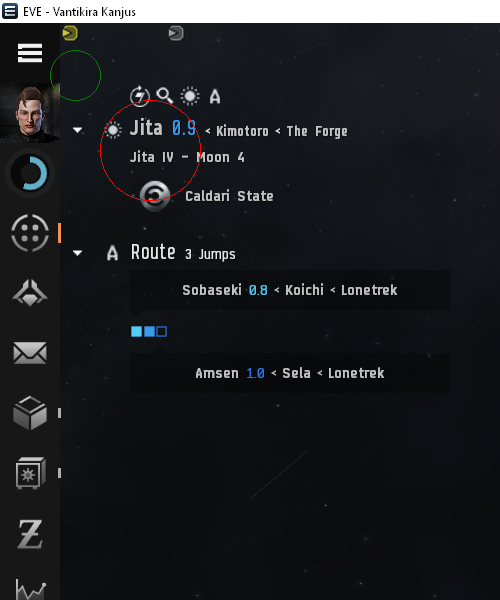

In [47]:
test_image_index = 0

prediction = model.predict(np.array([test_x[test_image_index]]))
result = ((prediction) * np.array([500, 600])) # reduction
print(result)
truth = (test_y[test_image_index] * np.array([500, 600])) # reduction
print(truth)

#mg = Image.fromarray(test_x[test_image_index]) 
img = Image.open(f"{path}\\{test_names[test_image_index]}")
img1 = ImageDraw.Draw(img)  
img1.ellipse((100,100,200,200), outline ="red")
img1.ellipse((50,50,100,100), outline ="Green")


img